## Overview

This analysis attempts to group together countries based on nothing more than the professed happiness of its citizens. To do so, we will be using data from the [2019 World Happiness Report](https://worldhappiness.report/ed/2019/#read) to build several clustering models. The primary models discussed in this analysis are:
* K-means
* Agglomerative Clustering
* Affinity Propagation
* Gaussian Mixture

Additionally, these models will be briefly demonstrated:
* DBSCAN
* HDBSCAN

Each model will be visualized in 3 different forms:
* A scatter plot, box plot and violin plot

Glossary:
* WHR - World Happiness Report
* GWP - Gallup World Poll
* WVS - World Value Surveys

#### Imports

In [2]:
import numpy as np    
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from sklearn.mixture import GaussianMixture 

import hdbscan

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics.cluster import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

import geopandas

#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
RS = 404 # Random state/seed
pd.set_option("display.max_columns",30) # Increase columns shown

## Data

The 2019 World Happiness Report dataset may be obtained from

https://s3.amazonaws.com/happiness-report/2019/Chapter2OnlineData.xls

The World Happiness Report is a landmark survey of the state of global happiness that ranks 156 countries by how happy their citizens perceive themselves to be. This year’s World Happiness Report focuses on happiness and the community: how happiness has evolved over the past dozen years, with a focus on the technologies, social norms, conflicts and government policies that have driven those changes.

It has 2 descriptor/ID variables (Country,Year), one response (Life Ladder), six proposed determinants of the response, and several additional variable that were either calculated or gather from external sources.

* `Country` - Name of the country.
* `Year` - Year of data collection.
* `Life Ladder` - _(survey,0-10)_ Cantril Life Ladder/Happiness score/subjective well-being. The national average response to the following question: 
    * "Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?"

**Six Hypothesized Underlying Determinants**:

* `Log_GDP` - _(calculated-normalized,external)_, Log GDP per capita in purchasing power parity. Constant 2011 international dollar prices from World Development Indicators (November 14, 2018)
* `Life_Expectancy` - _(partial-interpolated,external)_, Healthy life expectancies at birth are based on the data extracted from the World Health Organization's Global Health Observatory data repository
* `Social_support` - _(survey,binary)_ National average response to:
    * "If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?"
* `Freedom` - _(survey,binary)_, National average response to: 
    * "Are you satisfied or dissatisfied with your freedom to choose what you do with your life?"
* `Generosity` - _(survey,binary,calculated-residual)_ is the residual of regressing national average of response to: 
    * "Have you donated money to a charity in the past month?" on GDP per capita.
* `Corruption_Perception` - _(survey,2x-binary)_, National average response to two questions:
    * "Is corruption widespread throughout the government or not" 
    * "Is corruption widespread within businesses or not?"

**Additional inclusions**:
* `Positive affect` - _(survey,3x-binary)_, Average of three GWP positive affect measures (waves 3-7): happiness, laugh and enjoyment in Gallup World Poll(waves 3-7). Responses to the following three questions, respectively:
    * "Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Happiness?",
    * "Did you smile or laugh a lot yesterday?"
    * "Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Enjoyment?"

* `Negative affect` - _(survey,3x-binary)_, Average of three GWP negative affect measures: worry, sadness and anger in  Responses to the following three questions, respectively:
    * "Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Worry?",
    * "Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Sadness?"
    * "Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Anger?"

* "giniLadder" - _(multi,calculated-metastat)_, Inequality/distribution statistics of happiness scores by WP5-year from the GWP release.  WP5 is GWP's coding of countries, including some sub-country territories.
    * `sdLadder` Standard deviation of ladder by country-year 
    * `cvLadder` Standard deviation/Mean of ladder by country-year

* `giniIncGallup` - _(calculated-normalized,external)_,  Household Income International Dollars. Income variables are created by converting local currency to International Dollars (ID) using purchasing power parity (PPP) ratios.

* `giniIncWB` - _(partial,external)_, Unbalanced panel of yearly index. Data are based on primary household survey data obtained from government statistical agencies and World Bank country departments

* `giniIncWBavg` - _(calculated,external)_, the average of `giniIncWB` in the period 2000-2016. Most countries are missing some gini index period data.

* `Confidence_natGovt` - _(survey,binary,external)_, citizens' confidence in key institutions (WP139) Response to:
    * "Do you have confidence in each of the following, or not? How about the national government?"

* "WGI indicators of governance quality" - _(survey, amalgam, calculated, external)_, based on over 30 individual data sources produced by a variety of survey institutes, think tanks, non-governmental organizations, international organizations, and private sector firms, enterprise, citizen and expert survey respondents.
    * `Democratic Quality` - average "Voice and Accountability" and "Political Stability and Absence of Violence"
    * `Delivery Quality` -  average "Government Effectiveness", "Regulatory Quality", "Rule of Law", "Control of Corruption"

**Expanded data**:

* `trust_Gallup` and `trust_WVS*` - _(survey,binary)_, Percentage of respondents with positive-trust response to:
    * "Generally speaking, would you say that most people can be trusted or that you [have,need] to be [very] careful in dealing with people?"

Primary definitions:<br>
https://s3.amazonaws.com/happiness-report/2019/WHR19_Ch2A_Appendix1.pdf

Definitions (Democratic Quality, Delivery Quality, Confidence_natGovt):<br> 
https://s3.amazonaws.com/happiness-report/2019/WHR19_Ch2A_Appendix2.pdf

In [4]:
whr = pd.read_excel('data/WHR2019.xls')

In [5]:
#whr = pd.read_csv('data/happiness_2016.csv')
whr.columns

Index(['Country name', 'Year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate)',
       'GINI index (World Bank estimate), average 2000-16',
       'gini of household income reported in Gallup, by wp5-year',
       'Most people can be trusted, Gallup',
       'Most people can be trusted, WVS round 1981-1984',
       'Most people can be trusted, WVS round 1989-1993',
       'Most people can be trusted, WVS round 1994-1998',
       'Most people can be trusted, WVS round 1999-2004',
       'Most people can be trusted, WVS round 2005-2009',
       'Most people can be trusted, WV

In [6]:
# Shortened and cleaned names, most are derived from WHR2019 paper
full_colnames = [
    'Country', 'Year', 'Life_Ladder', 
    'Log_GDP','Social_support', 'Life_Expectancy', 'Freedom', 'Generosity','Corruption_Perception', 
    'Positive_affect', 'Negative_affect',
    'Confidence_natGovt', 'Democratic_Quality','Delivery_Quality', 
    'sdLadder','cvLadder',
    'giniIncWB','giniIncWBavg','giniIncGallup',
    'trust_Gallup',
    'trust_WVS81_84','trust_WVS89_93','trust_WVS94_98','trust_WVS99_2004','trust_WVS2005_09','trust_WVS2010_14'
]
core_col = full_colnames[:9]
ext_col = full_colnames[:14] + full_colnames[17:19]

In [7]:
whr.columns = full_colnames

In [23]:
# Shorten and Clean names for dot access
whr.columns = whr.columns.str.replace('Most people can be trusted','trust_in_people')
whr.columns = whr.columns.str.replace(' ','_')
whr.columns = whr.columns.str.replace('[(),]','') # Strip parens and commas
whr.columns

In [8]:
whr.iloc[np.r_[0:3,-3:0]] # HeadTail

,Country,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,sdLadder,cvLadder,giniIncWB,giniIncWBavg,giniIncGallup,trust_Gallup,trust_WVS81_84,trust_WVS89_93,trust_WVS94_98,trust_WVS99_2004,trust_WVS2005_09,trust_WVS2010_14
0,Afghanistan,2008,3.723590,7.168690,0.450662,50.799999,0.718114,0.177889,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,51.200001,0.678896,0.200178,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906,0.286315,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2010,4.758381,7.386629,0.539075,51.599998,0.600127,0.134353,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318,0.275833,NaN,NaN,NaN,NaN,NaN,NaN
1701,Zimbabwe,2016,3.735400,7.538829,0.768425,54.400002,0.732971,-0.068105,0.723612,0.737636,0.208555,0.699344,-0.900649,-1.374650,2.776363,0.743257,NaN,0.432,0.596690,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1702,Zimbabwe,2017,3.638300,7.549491,0.754147,55.000000,0.752826,-0.069670,0.751208,0.806428,0.224051,0.682647,-0.988153,-1.350867,2.656848,0.730244,NaN,0.432,0.581484,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942
1703,Zimbabwe,2018,3.616480,7.553395,0.775388,55.599998,0.762675,-0.038384,0.844209,0.710119,0.211726,0.550508,NaN,NaN,2.498696,0.690919,NaN,0.432,0.541772,NaN,NaN,NaN,NaN,0.116683,NaN,0.082942


## Exploratory Data Analysis

The dataset contains NA values, however there are a few examples where a field's contribution to happiness is 0.0. This is likely a side effect of having a modeled rather than purely gathered dataset. One possibility is that if a country ranked the lowest for that particular characteristic it was simply zeroed out.

Happiness_Score is the summation of Economy_GDP_per_Capita, Family, Health_Life_Expectancy, Freedom, Trust_Government_Corruption, Generosity, and Dystopia_Residual within a margin of error between the confidence intervals. 

Other than Country, Region, and Happiness Rank, all of the variables are continuous floating point.

In [9]:
whr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 26 columns):
Country                  1704 non-null object
Year                     1704 non-null int64
Life_Ladder              1704 non-null float64
Log_GDP                  1676 non-null float64
Social_support           1691 non-null float64
Life_Expectancy          1676 non-null float64
Freedom                  1675 non-null float64
Generosity               1622 non-null float64
Corruption_Perception    1608 non-null float64
Positive_affect          1685 non-null float64
Negative_affect          1691 non-null float64
Confidence_natGovt       1530 non-null float64
Democratic_Quality       1558 non-null float64
Delivery_Quality         1559 non-null float64
sdLadder                 1704 non-null float64
cvLadder                 1704 non-null float64
giniIncWB                643 non-null float64
giniIncWBavg             1502 non-null float64
giniIncGallup            1335 non-null float64
trus

In [10]:
whr.isna().sum()

Country                     0
Year                        0
Life_Ladder                 0
Log_GDP                    28
Social_support             13
Life_Expectancy            28
Freedom                    29
Generosity                 82
Corruption_Perception      96
Positive_affect            19
Negative_affect            13
Confidence_natGovt        174
Democratic_Quality        146
Delivery_Quality          145
sdLadder                    0
cvLadder                    0
giniIncWB                1061
giniIncWBavg              202
giniIncGallup             369
trust_Gallup             1524
trust_WVS81_84           1579
trust_WVS89_93           1484
trust_WVS94_98           1086
trust_WVS99_2004         1213
trust_WVS2005_09         1074
trust_WVS2010_14         1033
dtype: int64

In [11]:
whr[whr[core_col].isna().any(axis=1)].shape # 188 entries have at least 1 missing value from the core attributes

(188, 26)

We can see a substantial portion of the values are missing, particularly in WVS reports of people's perceived trust in others.

In [12]:
whr.describe()

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,sdLadder,cvLadder,giniIncWB,giniIncWBavg,giniIncGallup,trust_Gallup,trust_WVS81_84,trust_WVS89_93,trust_WVS94_98,trust_WVS99_2004,trust_WVS2005_09,trust_WVS2010_14
count,1704.000000,1704.000000,1676.000000,1691.000000,1676.000000,1675.000000,1622.000000,1608.000000,1685.000000,1691.000000,1530.000000,1558.000000,1559.000000,1704.000000,1704.000000,643.000000,1502.000000,1335.000000,180.000000,125.000000,220.000000,618.000000,491.000000,630.000000,671.000000
mean,2012.332160,5.437155,9.222456,0.810570,63.111971,0.733829,0.000079,0.751315,0.709368,0.265679,0.481973,-0.136053,-0.001390,2.026707,0.392121,0.370000,0.385438,0.447771,0.226295,0.390480,0.283925,0.249574,0.268070,0.264336,0.237493
std,3.688072,1.121149,1.185794,0.119210,7.583622,0.144115,0.163365,0.186074,0.107984,0.084707,0.192059,0.876074,0.975849,0.401484,0.124661,0.083232,0.082396,0.108505,0.119079,0.123309,0.113226,0.118126,0.145120,0.160169,0.157482
min,2005.000000,2.661718,6.457201,0.290184,32.299999,0.257534,-0.336385,0.035198,0.362498,0.083426,0.068769,-2.448228,-2.144974,0.863034,0.133908,0.240000,0.211000,0.200969,0.066618,0.176535,0.066020,0.048720,0.075872,0.038242,0.031518
25%,2009.000000,4.610970,8.304428,0.747512,58.299999,0.638436,-0.115534,0.696083,0.621855,0.205414,0.334735,-0.790461,-0.711416,1.743369,0.310139,0.305000,0.321429,0.368424,0.139773,0.290300,0.223553,0.176876,0.155833,0.144976,0.118725
50%,2012.000000,5.339557,9.406206,0.833098,65.000000,0.752731,-0.022080,0.805775,0.718541,0.254544,0.464109,-0.227386,-0.218633,1.973070,0.372744,0.352000,0.371000,0.426541,0.198450,0.380174,0.292383,0.229924,0.232000,0.198380,0.193531
75%,2015.000000,6.273522,10.193060,0.904432,68.300003,0.848155,0.093522,0.876458,0.801530,0.314896,0.614862,0.650468,0.699971,2.242300,0.456311,0.428000,0.432200,0.514803,0.281627,0.478149,0.341741,0.294242,0.385469,0.391370,0.335000
max,2018.000000,8.018934,11.770276,0.987343,76.800003,0.985178,0.677743,0.983276,0.943621,0.704590,0.993604,1.575009,2.184725,3.718958,1.022769,0.634000,0.626000,0.961435,0.640332,0.571719,0.594595,0.647737,0.637185,0.737305,0.661757


Most of the data seems to be of a similar magnitude, with Ladder, Log GDP, and life expectancy being the largest exceptions

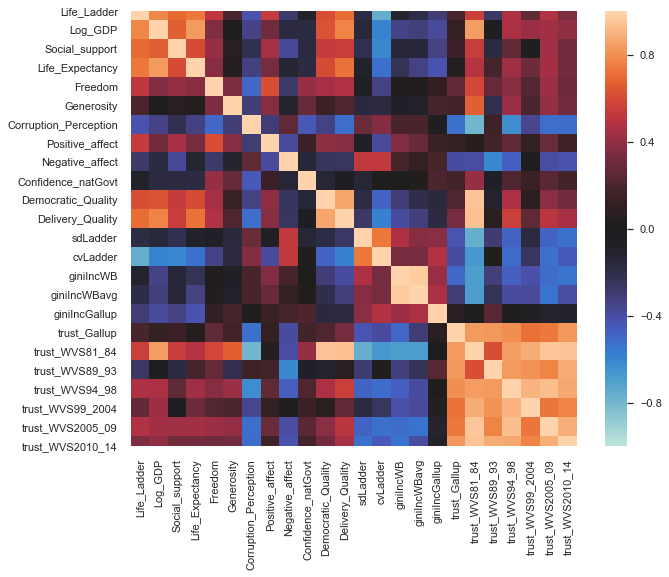

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
corrmat = whr.drop(columns='Year').corr() # Omit year
sns.heatmap(corrmat,-1,1,ax=ax,center=0);

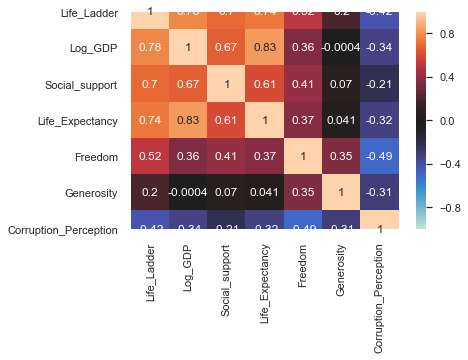

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
corrmat = whr[core_col].drop(columns='Year').corr() # Omit year
sns.heatmap(corrmat,-1,1,ax=ax,center=0,annot=True);

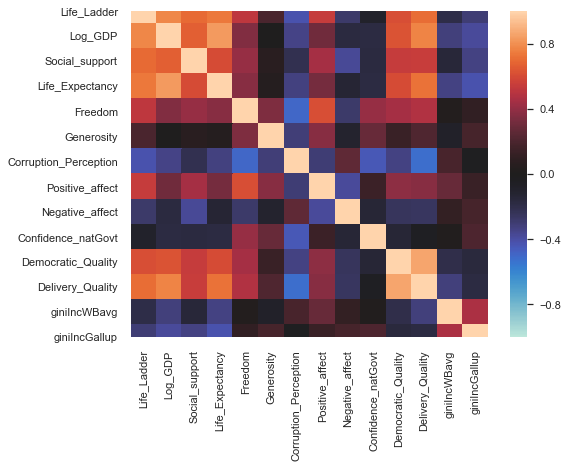

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
corrmat = whr[ext_col].drop(columns='Year').corr() # Omit year
sns.heatmap(corrmat,-1,1,ax=ax,center=0);

The upper left-hand square was likely by design, if happiness (life_ladder) is the statistic we are looking to understand, the attributes to immediately follow are likely what most consider large contributing factors.

Intuitive correlations: 
* correlation between all trust statistics
* Democratic Quality <+> Delivery Quality
* SDMean Ladder <-> Ladder 
* GINI index <+> GINI index mean

Potentially interesting correlations:
* trust WVS 81-84 <+> Democratic+Delivery Quality
* trust WVS 81-84 <+> log GDP
* trust WVS 81-84 <-> Perceptions of corruption

While the trust 81-84 could be an interesting variable to investigate, it is also worth remembering that this attribute has the most null values out of all, so these should be taken with a grain of salt.



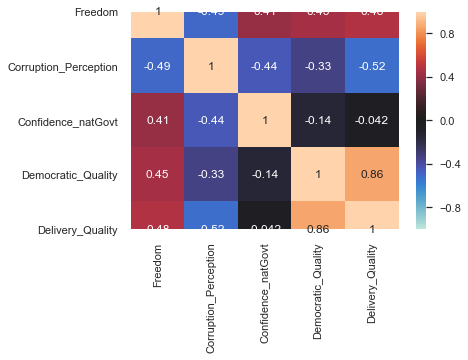

In [16]:
gov_col = ['Freedom', 'Corruption_Perception', 'Confidence_natGovt','Democratic_Quality', 'Delivery_Quality']
fig, ax = plt.subplots(figsize=(6,4))
corrmat = whr[gov_col].corr() # Omit year
sns.heatmap(corrmat,-1,1,ax=ax,center=0,annot=True);

In [17]:
whr_ext = whr[ext_col].copy() # Using an extended, but not quite full, version of dataset

In [18]:
whr_ext.groupby('Country').Year.count().describe()

count    165.000000
mean      10.327273
std        3.371624
min        1.000000
25%        9.000000
50%       12.000000
75%       13.000000
max       13.000000
Name: Year, dtype: float64

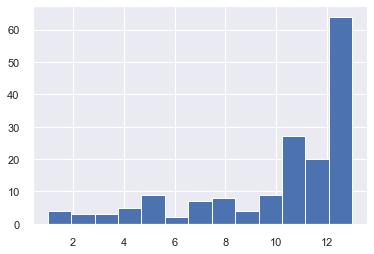

In [19]:
whr_ext.groupby('Country').Year.count().hist(bins=13);

Almost half of all countries in the dataset have an entry for all years that the survey has been conducted. Additionally, 75% of countries have at least 9 years worth of data entries. 

In [20]:
#From:  00BF11 -> BF2200
rygscale = [
    [0,'rgb(191, 34, 0)'],
    [0.2,'rgb(191, 75, 0)'],
    [0.3,'rgb(191, 116, 0)'],
    [0.4,'rgb(191, 156, 0)'],
    [0.5,'rgb(184, 191, 0)'],
    [0.6,'rgb(144, 191, 0)'],
    [0.7,'rgb(103, 191, 0)'],
    #[0.8,'rgb(63, 191, 0)'],
    #[0.9,'rgb(22, 191, 0)'],
    [0.8,'rgb(0, 191, 17)'], # Display highest happiness ranks as vibrant green
    [0.9,'rgb(30, 223, 29)'],
    [1,'rgb(61, 255, 41)']]
# https://convertingcolors.com/rgb-color-191_34_0.html
# http://www.perbang.dk/rgbgradient/

In [21]:
whr_recent = whr_ext.iloc[whr_ext.groupby('Country').Year.idxmax()]
data = [
    go.Choropleth(
        locations = whr_recent.Country,#whrffl_imp.index, 
        locationmode = 'country names',
        z = whr_recent['Life_Ladder'],
        text = ['{} ({})'.format(c,y) for c, y in zip(whr_recent.Country, whr_recent.Year)],
        hoverinfo='z+text',
        colorscale = rygscale,
        marker = go.choropleth.Marker(line = go.choropleth.marker.Line(color = 'rgb(255,255,255)',width = 0.15)),
        colorbar = go.choropleth.ColorBar(title = 'Happiness Score',xpad=0)
    )
]

layout = go.Layout(
    title = go.layout.Title(text = 'World Happiness 2019<br>(Cantrill Life Ladder)', yanchor='top'),
    geo = go.layout.Geo(
        showcoastlines = True,
        landcolor = 'lightgray',
        showland = True,
        showframe=False,
        projection = go.layout.geo.Projection(type = 'equirectangular')#'natural earth')
    ),
    annotations = [
        go.layout.Annotation(x = 0.85,y = 0.01,xref = 'paper',yref = 'paper',xanchor='right', yanchor='bottom',
        text = 'Source: <a href="https://worldhappiness.report/ed/2019/#read">World Happiness Report 2019</a>',
        showarrow = False),
        go.layout.Annotation(x = 0, y = -0.15, xref = 'paper',yref = 'paper',align='left',font={'size':9},
        text = '''
        "Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top.<br>
         The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you.<br>
         On which step of the ladder would you say you personally feel you stand at this time?"
        ''',
        showarrow = False)
    ]
)

In [22]:
fig = go.Figure(data = data, layout = layout)
# To run in notebook, uncomment iplot, else it will save as html file
#pio.write_html(fig, file='whr2019.html', include_plotlyjs='cdn', full_html=False)
iplot(fig, filename = 'world-map')

In [112]:
# This dictionary was a mapping between the WHR country names and geopandas country names.
# Left in notebook for potential future use.
# format: whr.Country : world.name
whr_world = {
    'Bahrain' : None,
    'Bosnia and Herzegovina' : 'Bosnia and Herz.',
    'Central African Republic' : 'Central African Rep.',
    'Congo (Brazzaville)' : 'Congo',
    'Congo (Kinshasa)' : 'Dem. Rep. Congo',
    'Czech Republic' : 'Czech Rep.',
    'Dominican Republic' : 'Dominican Rep.',
    'Hong Kong S.A.R. of China' : None,
    'Ivory Coast' : "Côte d'Ivoire",
    'Laos' : 'Lao PDR',
    'Malta' : None,
    'Mauritius' : None,
    'North Cyprus' : 'Cyprus',
    'Palestinian Territories' : 'Palestine',
    'Singapore' : None,
    'Somaliland region' : 'Somalia',
    'South Korea' : 'Korea',
    'South Sudan' : 'S. Sudan',
    'Taiwan Province of China' : 'Taiwan'}

### Aggregating

Ideally, we would simply use the most up to data that we have for each country, unfortunately, that causes some problems.

#### Take latest

In [22]:
# Get latest year indices
latest_idx = whr_ext.groupby('Country').Year.idxmax()
whrl = whr_ext.iloc[latest_idx].set_index('Country')
# Check NAs in the core data set
whrl[whrl[core_col[1:]].isna().any(axis=1)]

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
Bahrain,2017,6.227321,10.675694,0.875747,68.500000,0.905859,0.128193,NaN,0.813571,0.289760,NaN,-1.167434,0.226644,NaN,0.446609
Cambodia,2018,5.121838,8.253352,0.794605,61.599998,0.958305,0.033787,NaN,0.844593,0.414346,NaN,NaN,NaN,NaN,0.603439
China,2018,5.131434,9.694376,0.787605,69.300003,0.895378,-0.174899,NaN,0.855784,0.189640,NaN,NaN,NaN,0.425000,0.538206
Cuba,2006,5.417869,9.676425,0.969595,68.440002,0.281458,NaN,NaN,0.646712,0.276602,0.513176,-0.706359,-0.543394,NaN,NaN
Cyprus,2018,6.276443,NaN,0.825573,73.699997,0.794215,NaN,0.848337,0.750122,0.298021,0.352440,NaN,NaN,0.326167,0.448661
Egypt,2018,4.005451,9.293960,0.758824,61.700001,0.681654,-0.222930,NaN,0.492261,0.285184,NaN,NaN,NaN,0.312000,0.323929
Gambia,2018,4.922099,7.376554,0.684800,55.000000,0.718729,NaN,0.691070,0.804012,0.379208,0.757543,NaN,NaN,0.422667,0.592391
Jordan,2018,4.638934,9.024435,0.799544,66.800003,0.762420,-0.183490,NaN,NaN,NaN,NaN,NaN,NaN,0.343000,0.391051
Kosovo,2018,6.391826,NaN,0.822407,65.149826,0.889737,NaN,0.922078,0.778271,0.170248,0.347547,NaN,NaN,0.289909,0.402302


That is quite a few missing values from the core attributes. Dropping these values would certainly degrade the quality of conclusions we are able to draw. Let's try another means of aggregating the data.

#### Mean across years

In [23]:
whr_mean = whr_ext.groupby('Country').mean()
whr_mean[whr_mean[core_col[1:]].isna().any(axis=1)]

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
China,2012.000000,4.984993,9.284457,0.780020,67.969230,0.829893,-0.191763,NaN,0.818346,0.158571,NaN,-1.081073,-0.229781,0.425,0.519979
Cuba,2006.000000,5.417869,9.676425,0.969595,68.440002,0.281458,NaN,NaN,0.646712,0.276602,0.513176,-0.706359,-0.543394,NaN,NaN
North Cyprus,2014.666667,5.682304,NaN,0.829782,NaN,0.779380,NaN,0.700919,0.646726,0.347834,0.414453,NaN,NaN,NaN,0.332236
Oman,2011.000000,6.852982,10.648312,NaN,65.500000,0.916293,-0.008942,NaN,NaN,0.295164,NaN,-0.314025,0.295601,NaN,0.494790
Somalia,2015.000000,5.183286,NaN,0.601511,49.899999,0.919690,NaN,0.435836,0.875515,0.195745,0.701591,-2.213750,-2.112246,NaN,0.508235
Somaliland region,2010.500000,4.909162,NaN,0.820706,NaN,0.795702,NaN,0.418910,0.768032,0.117528,0.634423,NaN,NaN,NaN,0.515988
Swaziland,2014.500000,4.539328,8.922841,0.808210,NaN,0.658565,-0.126601,0.804796,0.822484,0.251696,0.521415,-0.897581,-0.541850,0.523,0.710633
Turkmenistan,2013.888889,5.614522,9.517484,0.930100,60.826667,0.760401,-0.001878,NaN,0.641446,0.199920,NaN,-1.031149,-1.533028,NaN,0.263699


We've improved in terms of NA quantity, but now we have a meaningless Year column and data that isn't representative of the most up to date information available. We need a method that can aggregate the data while still using the latest available information. Luckily, we already have most of the information needed to do this.

#### Forward Fill Latest 

In [55]:
# Propagate the last available entry forward
# whrffl = whr_ext.groupby('Country').ffill().iloc[latest_idx].set_index('Country')
whrffl = whr_ext.groupby(['Country']).apply(lambda x: x.ffill()).iloc[latest_idx].set_index('Country')
whrffl[whrffl[core_col[1:]].isna().any(axis=1)]

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
China,2018,5.131434,9.694376,0.787605,69.300003,0.895378,-0.174899,NaN,0.855784,0.189640,NaN,-0.877810,-0.064555,0.425,0.538206
Cuba,2006,5.417869,9.676425,0.969595,68.440002,0.281458,NaN,NaN,0.646712,0.276602,0.513176,-0.706359,-0.543394,NaN,NaN
North Cyprus,2018,5.608056,NaN,0.837392,NaN,0.797066,NaN,0.613837,0.480453,0.261868,0.378324,NaN,NaN,NaN,0.200969
Oman,2011,6.852982,10.648312,NaN,65.500000,0.916293,-0.008942,NaN,NaN,0.295164,NaN,-0.314025,0.295601,NaN,0.494790
Somalia,2016,4.667941,NaN,0.594417,50.000000,0.917323,NaN,0.440802,0.891423,0.193282,0.700682,-2.134841,-2.125518,NaN,0.491746
Somaliland region,2012,5.057314,NaN,0.786291,NaN,0.758219,NaN,0.333832,0.735189,0.152428,0.651242,NaN,NaN,NaN,0.533575
Swaziland,2018,4.211565,8.946771,0.779270,NaN,0.709974,-0.179938,0.692341,0.824355,0.252339,0.689549,-0.897581,-0.541850,0.523,0.732568
Turkmenistan,2018,4.620602,9.749464,0.984489,62.200001,0.857774,0.237280,NaN,0.612210,0.189025,NaN,-1.153554,-1.545981,NaN,0.271070


Now this is where we want to be. Using forward fill, we are able to preserve the latest available information while still reducing NA values. To a certain extent, we've corrupted the accuracy of `Year`, since it no long is exact measures from that year, but rather the last available data in each column up to that year. We'll keep it around for now, but drop it before we do any modeling.

The NaNs we are left with indicate that certain countries have no data available in any year of surveying.

In [56]:
# Save NA country index for later use for future dataframe build
naidx = whrffl[whrffl[core_col[1:]].isna().any(axis=1)].index
# Save underlying 'natural' indices
naiidx = whrffl.reset_index()[whrffl.reset_index()[core_col[1:]].isna().any(axis=1)].index
#nacnty = whr_lateff[whr_lateff[core_col].isna().any(axis=1)].Country.values
whrffl[core_col[1:]].isna().sum()

Year                     0
Life_Ladder              0
Log_GDP                  3
Social_support           1
Life_Expectancy          3
Freedom                  0
Generosity               4
Corruption_Perception    4
dtype: int64

We can't call it quits yet, these remaining missing values need to be addressed before we can do any sort of clustering. There are quite a few easy methods we could use to fill in these values, we could just enter 0 and move on, but let's try to be smart about this.

### Imputation

Somewhere in between filling values with a constant and engineering values by hand is variable imputation. If the stakes were higher, we'd want to try things like crafting missing GDP values with giniInc or values even just pull from another external data source, but let's keep it local and let some algorithms do the work for us.

* looking at region relationships (China and HongKong China)
* training models for each column of interest with a missing value
* pull for external sources
* use Freedom,Confidence_natGovt,Democratic_Quality,Delivery_Quality to try and derive `Corruption_Perception`

There is a case to be made that forward filling prior to imputation is not optimal since we are not allowing the algorithm to fully transform true missing values. However, we must always consider what the data represents when making any decisions.  

In the worst case, a country has data entry in 2005 (the first survey year) and has NaN values for every year thereafter. In such a case, using forward fill would propagate the value up to 2018 (latest survey year) potentially meaning it is outdated and no longer relevant. The alternative is to allow the imputer to derive these missing values with the other non-missing values as input. The question we must ask is do we value real, but potential outdated data, over fake, but temporally responsive data.

In all likelihood, the change that a given country experiences over a 13 year period is smaller than what we could accurately impute. If the dataset spanned, say, a generation (25 years) then perhaps more weight should be given to the imputation option.

As with most decision made during an analysis, this could be thoroughly vetted and a true optimal solution discovered, but again, the stakes are low enough to just leave well enough alone. Additionally, as shown below, the difference between each method is largely insignificant.

In [57]:
# fit on non-aggregated extended data
imputer = IterativeImputer(estimator=BayesianRidge(),random_state=RS,max_iter=15).fit(whr_ext.iloc[:,1:])

We fit on the non-mutated data to maintain data purity and increase the number of samples the imputer has at its disposal.

#### FFill difference

In [58]:
# Impute on latest data
whrl_imp = pd.DataFrame(imputer.transform(whrl), columns=whrl.columns,index=whrl.index)
# Impute on latest forward filled data
whrffl_imp = pd.DataFrame(imputer.transform(whrffl), columns=whrffl.columns,index=whrffl.index)

In [59]:
# whrl.loc[naidx] # Take latest Before
whrffl.loc[naidx] # FFill-latest Before

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
China,2018,5.131434,9.694376,0.787605,69.300003,0.895378,-0.174899,NaN,0.855784,0.189640,NaN,-0.877810,-0.064555,0.425,0.538206
Cuba,2006,5.417869,9.676425,0.969595,68.440002,0.281458,NaN,NaN,0.646712,0.276602,0.513176,-0.706359,-0.543394,NaN,NaN
North Cyprus,2018,5.608056,NaN,0.837392,NaN,0.797066,NaN,0.613837,0.480453,0.261868,0.378324,NaN,NaN,NaN,0.200969
Oman,2011,6.852982,10.648312,NaN,65.500000,0.916293,-0.008942,NaN,NaN,0.295164,NaN,-0.314025,0.295601,NaN,0.494790
Somalia,2016,4.667941,NaN,0.594417,50.000000,0.917323,NaN,0.440802,0.891423,0.193282,0.700682,-2.134841,-2.125518,NaN,0.491746
Somaliland region,2012,5.057314,NaN,0.786291,NaN,0.758219,NaN,0.333832,0.735189,0.152428,0.651242,NaN,NaN,NaN,0.533575
Swaziland,2018,4.211565,8.946771,0.779270,NaN,0.709974,-0.179938,0.692341,0.824355,0.252339,0.689549,-0.897581,-0.541850,0.523,0.732568
Turkmenistan,2018,4.620602,9.749464,0.984489,62.200001,0.857774,0.237280,NaN,0.612210,0.189025,NaN,-1.153554,-1.545981,NaN,0.271070


In [60]:
# whrl_imp.loc[naidx] # Take latest After
whrffl_imp.loc[naidx] #FFill-latest After

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
China,2018.0,5.131434,9.694376,0.787605,69.300003,0.895378,-0.174899,0.598125,0.855784,0.189640,0.681986,-0.877810,-0.064555,0.425000,0.538206
Cuba,2006.0,5.417869,9.676425,0.969595,68.440002,0.281458,-0.113951,0.842834,0.646712,0.276602,0.513176,-0.706359,-0.543394,0.325290,0.271920
North Cyprus,2018.0,5.608056,10.096858,0.837392,70.319717,0.797066,-0.142033,0.613837,0.480453,0.261868,0.378324,-0.045114,0.384631,0.209252,0.200969
Oman,2011.0,6.852982,10.648312,0.905146,65.500000,0.916293,-0.008942,0.621081,0.795146,0.295164,0.607523,-0.314025,0.295601,0.427632,0.494790
Somalia,2016.0,4.667941,6.700755,0.594417,50.000000,0.917323,0.130703,0.440802,0.891423,0.193282,0.700682,-2.134841,-2.125518,0.481401,0.491746
Somaliland region,2012.0,5.057314,8.887497,0.786291,60.650726,0.758219,0.074972,0.333832,0.735189,0.152428,0.651242,-0.133132,0.440827,0.355993,0.533575
Swaziland,2018.0,4.211565,8.946771,0.779270,57.651606,0.709974,-0.179938,0.692341,0.824355,0.252339,0.689549,-0.897581,-0.541850,0.523000,0.732568
Turkmenistan,2018.0,4.620602,9.749464,0.984489,62.200001,0.857774,0.237280,0.896775,0.612210,0.189025,0.649490,-1.153554,-1.545981,0.292400,0.271070


In [61]:
whrffl_imp.loc[naidx] - whrl_imp.loc[naidx] # difference

,Year,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,,
China,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,-0.045064,0.000000e+00,0.0,0.083032,-1.031326,-0.434279,0.000000,0.0
Cuba,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0
North Cyprus,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Oman,0.0,0.0,0.0,4.440892e-16,0.000000,0.0,0.0,0.000000,1.110223e-16,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Somalia,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Somaliland region,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Swaziland,0.0,0.0,0.0,0.000000e+00,-0.099673,0.0,0.0,0.000000,0.000000e+00,0.0,0.000000,-0.503161,-0.216707,0.000000,0.0
Turkmenistan,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.169159,0.000000e+00,0.0,-0.001948,-1.049260,-1.661919,0.045808,0.0


With a few exceptions, there is no difference between the filled data fields. Looking at core columns, `Corruption_Perception` is the only attribute with a non-negligible difference for Turkmenistan.

## Models

* K-means
* Agglomerative Clustering
* Affinity Propagation
* Gaussian Mixture
* DBSCAN
* HDBSCAN

#### Helper functions

In [62]:
def plot_cluster(x, y, labels, data=None, centers=None, title='', **kwargs):
    """ Plot data from a clustering algorithm using dataframe column names
    
    If array-like values used for ``x``, ``y``, ``labels``, function will
    act as a loose wrapper to `matplotlib.plot.scatter()`
    
    Args:
        x, y : array-like, or str  
            axis data to be plotted or names of columns in ``data``
        labels: pandas.Series, or str
            predicted group labels, if string value, will be used as column in ``data``
        data : pandas.Dataframe, optional (default: None)
            DataFrame containing the data to be plotted along with the predicted groups
        centers : pd.DataFrame, optional (default: None)
            centers of the determined groups, only available if ``data`` is not None
        title : str, optional (default: '')
            plot title
        **kwargs : keyword arguments, optional
            arguments to pass to plt.scatter
    
    Returns:        
        ax : matplotlib Axes
            the Axes object with the plot drawn onto it.
    """
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    if isinstance(labels,str):
        labels = data[labels]
        gcounts = labels.value_counts(sort=False)
    nlabels = labels.nunique()
    bounds = np.arange(labels.min(),nlabels+1)
    
    # 20 distinct colors, more visible and differentible than tab20 
    # https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    cset = ['#3cb44b', '#ffe119', '#4363d8','#e6194b', 
        '#f58231','#911eb4', '#46f0f0', '#f032e6', '#bcf60c', 
        '#fabebe', '#008080', '#e6beff','#800000', '#aaffc3'] # take 14

    # Add black in for negative label values
    cm = (mpl.colors.ListedColormap(cset, N=nlabels) if labels.min() == 0 
          else mpl.colors.ListedColormap(['#000000']+cset, N=nlabels+1))    
    
    # Descrete colorbar setup 
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8]) # 'Magic' numbers for colorbar spacing
    norm = mpl.colors.BoundaryNorm(bounds,cm.N)
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cm, norm=norm,ticks=bounds+0.5, boundaries=bounds)
    cb.set_ticklabels(bounds)
    
    ax.scatter(x,y,data=data,cmap=cm,edgecolors='face',c=labels,**kwargs)
    
    if centers is not None:
        #center_size = gcounts*4 # scale ♦ size by number of group members
        center_size = np.exp(centers['Life_Ladder'])*75 # scale ♦ size by Life_Ladder score
        ax.scatter(x,y,data=centers,marker='D',c=centers.index.values,cmap=cm,
                       s=center_size, edgecolors='black',linewidths=1,alpha=0.7)
            
        ax.set_title('(color=group, ♦size=Happiness, ♦loc = group center)')
    
    if isinstance(x,str) and isinstance(y,str):       
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    
    fig.suptitle(title, fontsize=14)

    plt.show()
    return ax

In [63]:
def plot_boxolin(x,y,data):
    """ Plot a box plot and a violin plot.
    
    Args:
        x,y : str
            columns in `data` to be plotted. x is the 'groupby' attribute.
        data : pandas.DataFrame
            DataFrame containing `x` and `y` columns
    
    Returns:        
        axes : matplotlib Axes
            the Axes object with the plot drawn onto it.
    """
    fig,axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
    whr_grps.boxplot(column=y,by=[x],ax=axes[0]) # could use sns.boxplot, but why not try something different
    sns.violinplot(x,y,data = whr_grps,scale='area',ax=axes[1])
    axes[0].set_title(None)
    axes[0].set_ylabel(axes[1].get_ylabel())
    axes[1].set_ylabel(None)
    plt.show()
    return axes

In [64]:
def cluster(model, X, **kwargs):
    """ Run a clustering model and return predictions.
    
    Args:
        model : {sklearn.cluster, sklearn.mixture, or hdbscan}
            Model to fit and predict
        X : pandas.DataFrame
            Data used to fit `model`
        **kwargs : `model`.fit_predict() args, optional
            Keyword arguments to be passed into `model`.fit_predict()
    Returns:
        (labels,centers) : tuple(array, pandas.DataFrame)
            A tuple containing cluster labels and a DataFrame of cluster centers formated with X columns
    """
    clust_labels = model.fit_predict(X,**kwargs)
    centers = X.assign(**{model.__class__.__name__ : clust_labels} # assign a temp column to X with model name
                      ).groupby(model.__class__.__name__,sort=True).mean() # group on temp, gather mean of labels
    
    return (clust_labels, centers)

In [65]:
def score_clusters(X,labels):
    """ Calculate silhouette, calinski-harabasz, and davies-bouldin scores
    
    Args:
        X : array-like, shape (``n_samples``, ``n_features``)
            List of ``n_features``-dimensional data points. Each row corresponds
            to a single data point.

        labels : array-like, shape (``n_samples``,)
            Predicted labels for each sample.
    Returns:
        scores : dict
            Dictionary containing the three metric scores
    """
    scores = {'silhouette':silhouette_score(X,labels),
              'calinski_harabasz':calinski_harabasz_score(X,labels),
              'davies_bouldin':davies_bouldin_score(X,labels)
             }
    return scores

#### Setup Modeling Data

In [66]:
ss = StandardScaler()
whrX = pd.DataFrame(ss.fit_transform(whrffl_imp.drop(columns='Year')), columns=whrffl_imp.drop(columns='Year').columns, index=whrffl_imp.index)
whrX.head()

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
Country,,,,,,,,,,,,,,
Afghanistan,-2.499994,-1.435267,-2.398592,-1.636104,-3.047681,-0.458046,1.095187,-2.485333,1.123785,-0.792207,-1.930070,-1.417846,-1.260899,-1.406094
Albania,-0.412826,0.132356,-0.972327,0.670231,0.356675,0.141452,0.942003,0.052647,0.236524,-0.439633,0.535487,-0.077580,-1.003994,-0.090691
Algeria,-0.377876,0.251331,-0.040310,0.269130,-1.462538,-1.039297,0.186609,-1.020356,-0.032534,-0.890863,-0.848822,-0.781312,-1.333314,1.591967
Angola,-1.505664,-0.416054,-0.397013,-1.349603,-3.040082,-0.937353,0.592058,-1.130291,0.741230,0.243888,-0.636459,-1.141828,1.053499,-0.213697
Argentina,0.299485,0.457333,0.779928,0.684557,0.520461,-1.268567,0.705990,0.991837,0.252072,-1.307633,0.593400,-0.106015,0.901679,-0.494615


Most clustering algorithms are sensitive to the scale of data, standard scaling is advised.

In [67]:
whr_grps = whrX.copy() # clone which we many append cluster groups to.

### K-means

K-means clusters data by trying to separate samples in $k$ groups of equal variance, minimizing a criterion known as the _inertia_ or _within-cluster sum-of-squares_

https://scikit-learn.org/stable/modules/clustering.html#k-means

We first need to determine a suitable value for $k$. To do so, one heuristic we may use is the 'elbow' method.

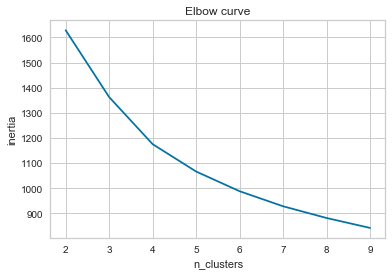

In [68]:
fig,ax = plt.subplots(figsize=(6, 4))
ax.plot(range(2,10),[KMeans(n_clusters=n,random_state=RS).fit(whrX).inertia_ for n in range(2,10)])
ax.set(**{'title':'Elbow curve','ylabel':'inertia','xlabel':'n_clusters'})
plt.show()

As seen in the plot above, this plots the inertia against the number of cluster groups. The purpose is to choose a point which maximizes inertia and minimizes the number of clusters, this point is referred to as the 'elbow' of the plot. In our case, the elbow is not extremely pronounced, but 4 clusters seems to be 'bending' point of the line.  

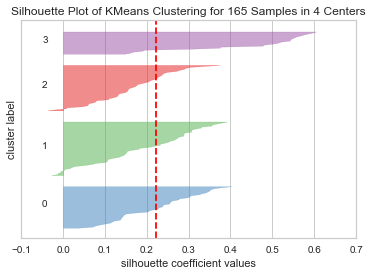

In [69]:
km = KMeans(n_clusters=4,random_state=RS)
SilhouetteVisualizer(km).fit(whrX).poof()

Here we can see that 4 clusters has decent enough performance for each cluster grouping. The plot represents the average silhouette coefficient for each sample on a per-cluster basis. The dashed red line indicates the average silhouette score across all clusters, if any group falls short of this line, it may be a indication that the cluster choice is not ideal.

Cluster[3], on average, has a significantly higher score, but it also has the fewest total members, as represented by the group's width in the visualization. Since all clusters exceed the average value to at least some degree, we will proceed on using 4 clusters.

In [70]:
clabels_km, cent_km = cluster(km, whrX)
whr_grps['KMeans'] = clabels_km
cent_km

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
KMeans,,,,,,,,,,,,,,
0,0.107225,0.499364,0.450004,0.561292,-0.461269,-0.731501,0.563635,-0.753835,-0.252992,-0.673411,0.177701,0.189130,-0.733602,-0.846647
1,-0.968981,-1.115563,-1.123546,-1.123262,-0.530333,0.321729,0.137103,-0.457920,0.753672,0.421141,-0.825546,-0.853758,0.285630,0.666190
2,0.332972,0.207092,0.420160,0.192586,0.597954,0.006969,0.185112,0.860779,-0.190336,-0.034563,0.102118,-0.044563,0.829858,0.307015
3,1.413251,1.293082,0.975827,1.227086,0.891537,0.566482,-1.721364,0.730128,-0.926834,0.310068,1.409504,1.748233,-0.990706,-0.632077


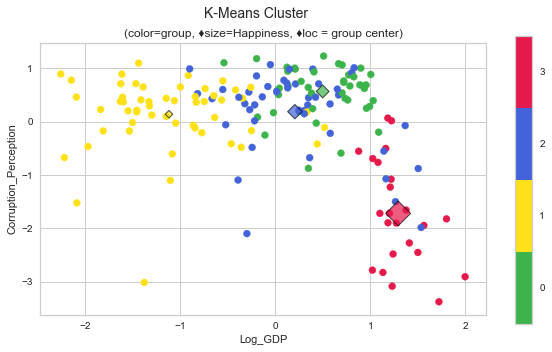

In [71]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'KMeans', data=whr_grps, centers=cent_km, title='K-Means Cluster');

Now, we can see more concretely how the silhouette visualization represents the data, at least for the case of `Corruption` and `GDP` attributes. Looking at the cluster dispersion, neither GDP nor Happiness has much bearing on perceived corruption until reaching the wealthiest nations, where it drops sharply.

In [72]:
cent_km.describe()

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.221117,0.220994,0.180611,0.214425,0.124472,0.040920,-0.208879,0.094788,-0.154122,0.005809,0.215944,0.259761,-0.152205,-0.126380
std,0.976900,1.002237,0.906118,0.989222,0.726736,0.563577,1.026210,0.819765,0.690956,0.492627,0.917189,1.088282,0.855814,0.728128
min,-0.968981,-1.115563,-1.123546,-1.123262,-0.530333,-0.731501,-1.721364,-0.753835,-0.926834,-0.673411,-0.825546,-0.853758,-0.990706,-0.846647
25%,-0.161826,-0.123572,0.034233,-0.136376,-0.478535,-0.177649,-0.327514,-0.531899,-0.421452,-0.194275,-0.129798,-0.246862,-0.797878,-0.685719
50%,0.220099,0.353228,0.435082,0.376939,0.068343,0.164349,0.161107,0.136104,-0.221664,0.137753,0.139910,0.072283,-0.223986,-0.162531
75%,0.603042,0.697793,0.581459,0.727740,0.671350,0.382918,0.279743,0.762790,0.045666,0.337836,0.485652,0.578906,0.421687,0.396808
max,1.413251,1.293082,0.975827,1.227086,0.891537,0.566482,0.563635,0.860779,0.753672,0.421141,1.409504,1.748233,0.829858,0.666190


The initial K-Means cluster plot seems to indicate that the populations with lower GDP per captia tend to believe there is more corruption in business/government and rate their lives lower on the Cantril Life Ladder. However, the relationship is not exact, as seen in cluster[0] happiness and GDP can increase to a certain extent while also increasing perceptions of corruption. 

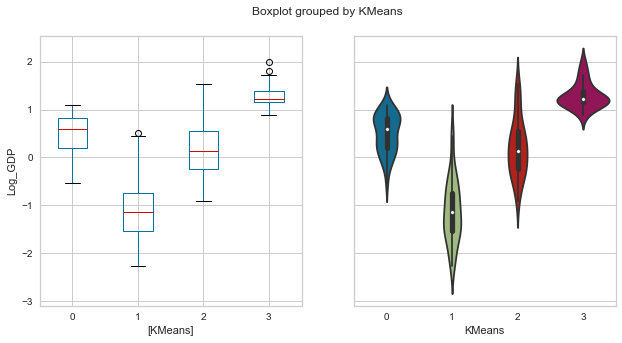

In [73]:
plot_boxolin('KMeans','Log_GDP', data = whr_grps);

In [74]:
scores_km = score_clusters(whrX,clabels_km)
pd.DataFrame([score_clusters(whrX,KMeans(n_clusters=n,random_state=RS).fit_predict(whrX)) for n in range(2,10)], index=range(2,10))

,silhouette,calinski_harabasz,davies_bouldin
2,0.250627,68.240342,1.473583
3,0.218425,56.332407,1.458299
4,0.223155,51.815454,1.467267
5,0.207049,46.643073,1.565098
6,0.212860,42.543303,1.489635
7,0.187045,39.199290,1.531604
8,0.179825,36.340180,1.616779
9,0.185598,33.989629,1.567083


### Agglomerative Clustering

Agglomerative clustering performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The hierarchy of clusters is represented as a tree or dendrogram where the root of the tree is the unique cluster that gathers all the samples, and the leaves are the clusters with only one sample.

https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

In [75]:
ac = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')
clabels_ac,cent_ac = cluster(ac, whrX)
whr_grps['AgglomerativeClustering'] = clabels_ac
cent_ac

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
AgglomerativeClustering,,,,,,,,,,,,,,
0,0.402045,0.454050,0.533844,0.480147,0.195623,-0.186684,0.266133,0.211264,-0.300157,-0.332329,0.214791,0.159060,-0.044172,-0.375563
1,-0.937664,-0.963593,-1.003734,-1.001937,-0.525592,0.081686,0.148570,-0.472275,0.663155,0.332682,-0.675974,-0.688059,0.324815,0.663159
2,1.517015,1.319089,1.016879,1.324479,1.024796,0.757579,-2.175405,0.712655,-0.980121,0.574577,1.533921,1.910826,-1.083430,-0.537756


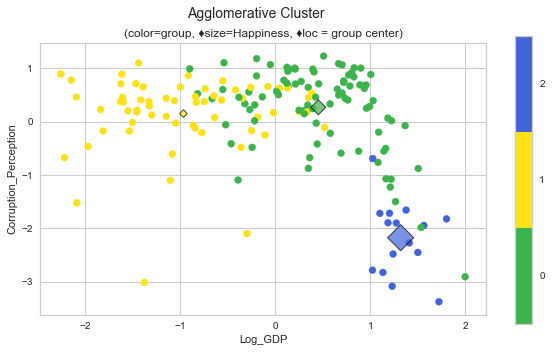

In [78]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'AgglomerativeClustering', data=whr_grps, centers=cent_ac, title='Agglomerative Cluster');

In [103]:
scores_ac = score_clusters(whrX,clabels_ac); scores_ac

{'silhouette': 0.19685197257469053,
 'calinski_harabasz': 48.287898116425936,
 'davies_bouldin': 1.4184695148698854}

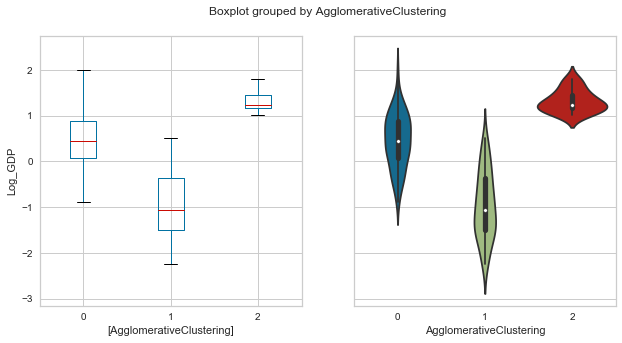

In [79]:
plot_boxolin('AgglomerativeClustering','Log_GDP',whr_grps);

### Affinity Propagation

In [81]:
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
clabels_ap, cent_ap = cluster(ap,whrX)
whr_grps['AffinityPropagation'] = clabels_ap
cent_ap

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
AffinityPropagation,,,,,,,,,,,,,,
0,-0.500617,-0.567265,-0.493516,-0.063212,0.293655,-0.052284,0.059636,-0.889806,0.309342,1.238099,-0.803796,-0.438167,-0.705119,-0.571035
1,-0.747142,-1.272132,-1.024236,-1.285140,-0.239862,0.221882,0.249245,0.015651,0.581525,0.484327,-0.424674,-0.730613,0.567298,0.978746
2,-1.279836,-1.313996,-1.903009,-1.561613,-1.223334,0.629845,0.294700,-1.372540,2.123510,-0.048624,-1.307729,-1.353406,0.344303,1.161366
3,0.222655,0.477397,0.609701,0.623043,-0.670309,-0.611355,0.745696,-0.853739,-0.286430,-1.206889,0.423385,0.222335,-0.646431,-0.864157
4,0.466757,0.073115,0.479527,0.338572,0.494534,-0.339993,0.483445,1.031721,-0.023339,-0.865418,0.270854,-0.206464,1.170024,0.098470
5,1.545599,1.302150,1.021691,1.311734,1.017160,0.768865,-1.940286,0.743073,-0.972178,0.444538,1.533331,1.879546,-1.083620,-0.663310
6,0.165519,-0.073751,0.656839,0.041118,0.987783,1.986966,0.606842,0.647387,-0.879889,0.636642,-0.532076,-0.595852,-0.587825,-0.545105
7,-1.006123,0.039446,0.132144,-0.950234,-0.139271,-1.012953,0.390493,0.606351,-0.366652,0.578280,0.364302,0.126509,2.534934,1.858689
8,0.723209,0.964495,0.369699,0.405695,0.909633,-0.012255,-0.688852,0.755897,-0.082930,0.769516,-0.092241,0.444170,0.454449,0.716381


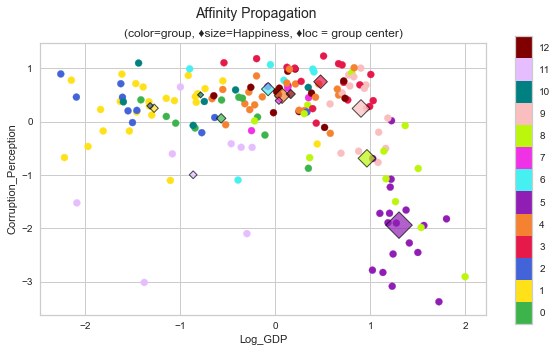

In [83]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'AffinityPropagation', data=whr_grps, centers=cent_ap, title='Affinity Propagation');

In [102]:
scores_ap = score_clusters(whrX,clabels_ap); scores_ap

{'silhouette': 0.1807914178898567,
 'calinski_harabasz': 27.84691838858024,
 'davies_bouldin': 1.5462700501887794}

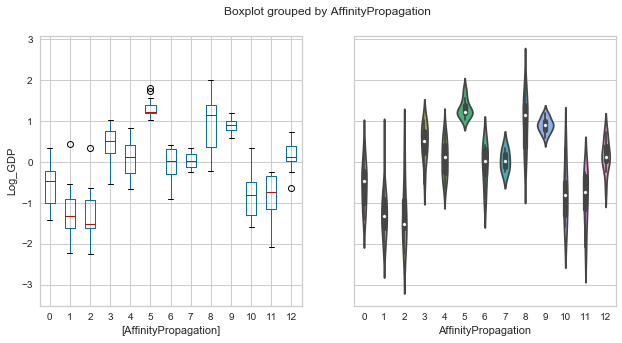

In [85]:
plot_boxolin('AffinityPropagation','Log_GDP',whr_grps);

Violin plot loses a fair bit of its aesthetics when we ramp up the cluster count

### Gaussian Mixture

A probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

https://scikit-learn.org/stable/modules/mixture.html#mixture

In [86]:
gm = GaussianMixture(n_components=3,init_params='kmeans', random_state=RS)
clabels_gm,cent_gm = cluster(gm,whrX)
whr_grps['GaussianMixture'] = clabels_gm
cent_gm

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
GaussianMixture,,,,,,,,,,,,,,
0,0.121003,0.290848,0.329489,0.305264,0.128359,-0.278011,0.404304,0.102988,-0.194147,-0.334905,0.082581,-0.020472,0.155404,-0.172694
1,1.366164,1.290100,0.946226,1.152916,0.845298,0.504250,-1.563515,0.725152,-0.836110,0.228849,1.328231,1.680884,-0.898514,-0.469166
2,-0.848250,-1.078975,-0.974230,-1.035616,-0.609042,0.194823,0.116398,-0.511258,0.708173,0.416979,-0.769506,-0.777091,0.188000,0.497728


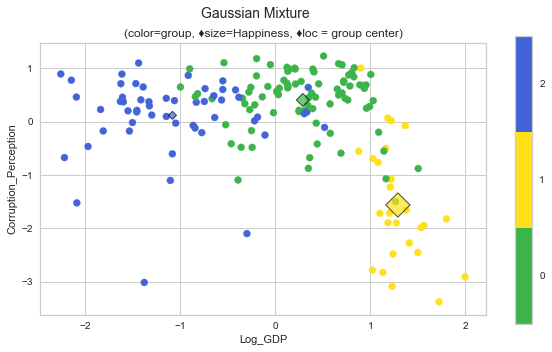

In [87]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'GaussianMixture', data=whr_grps, centers=cent_gm, title='Gaussian Mixture');

In [101]:
scores_gm = score_clusters(whrX,clabels_gm); scores_gm

{'silhouette': 0.17602676065311476,
 'calinski_harabasz': 46.98962716751056,
 'davies_bouldin': 1.6456170460570363}

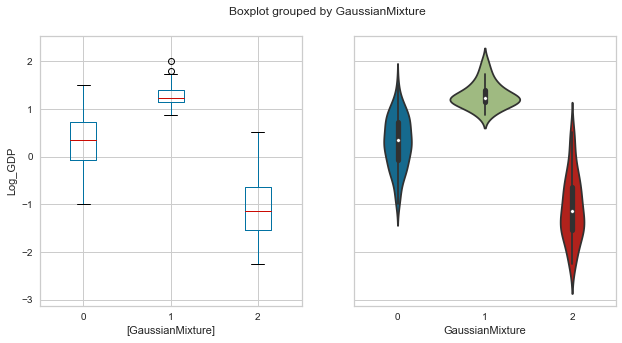

In [89]:
plot_boxolin('GaussianMixture','Log_GDP',whr_grps);

### DBSCAN

Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them.

In [90]:
db = DBSCAN(eps=0.3)
clabels_db,cent_db = cluster(db,whrX)
whr_grps['DBSCAN'] = clabels_db
cent_db

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
DBSCAN,,,,,,,,,,,,,,
-1,3.095167e-16,-5.800074e-16,-2.508095e-16,-8.504981e-16,-5.887546e-17,-4.642751e-17,2.839479e-16,-4.750409e-16,3.297026e-17,5.070018e-16,1.480297e-17,-1.076580e-17,2.893308e-16,6.331636e-16


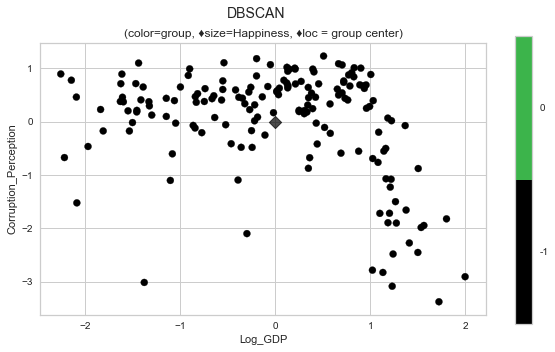

In [92]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'DBSCAN', data=whr_grps, centers=cent_db, title='DBSCAN');

Running with with a scaled version of the data failed to categorize any of the points at all. It considered every point to be too noisy group.

In [24]:
# Will throw an error, can't calculate scores when only "one" group exists.  
# score_clusters(whrX,clabels_db)

The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.

The usage of centroid distance limits the distance metric to Euclidean space.
A good value reported by this method does not imply the best information retrieval.

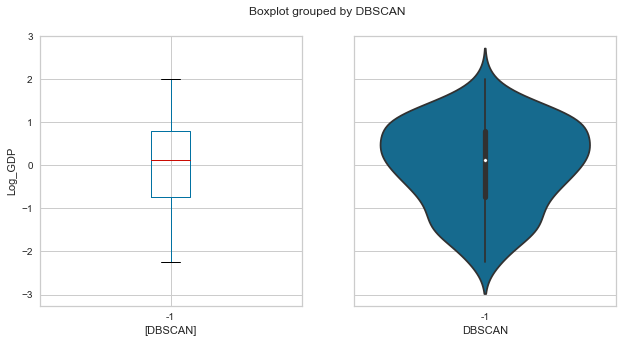

In [93]:
plot_boxolin('DBSCAN','Log_GDP',whr_grps);

Given this dataset has relatively low density, this model had substandard performance w.r.t the other contenders.

### HDBSCAN

Hierarchical Density-Based Spatial Clustering of Applications with Noise.
It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

In [94]:
hd = hdbscan.HDBSCAN()
clabels_hd, cent_hd = cluster(hd,whrX)
whr_grps['HDBSCAN'] = clabels_hd
cent_hd

,Life_Ladder,Log_GDP,Social_support,Life_Expectancy,Freedom,Generosity,Corruption_Perception,Positive_affect,Negative_affect,Confidence_natGovt,Democratic_Quality,Delivery_Quality,giniIncWBavg,giniIncGallup
HDBSCAN,,,,,,,,,,,,,,
-1,-0.325745,-0.191294,-0.233152,-0.234759,-0.124759,0.082251,0.087954,-0.227406,0.115121,0.213518,-0.318442,-0.256041,0.006019,0.152915
0,-0.594262,-1.306554,-1.067221,-1.435553,-0.471403,0.337794,0.436063,0.145287,0.848195,0.262831,-0.547068,-0.673820,0.313713,0.926564
1,0.548691,0.145915,0.517590,0.398214,0.540105,-0.527929,0.466860,1.033615,-0.025376,-0.973451,0.332459,-0.177761,1.218192,0.047480
2,1.012796,0.955901,0.821159,0.996843,0.254934,-0.072167,-0.715967,0.167328,-0.629233,-0.261801,1.103414,1.216625,-0.836442,-0.831162


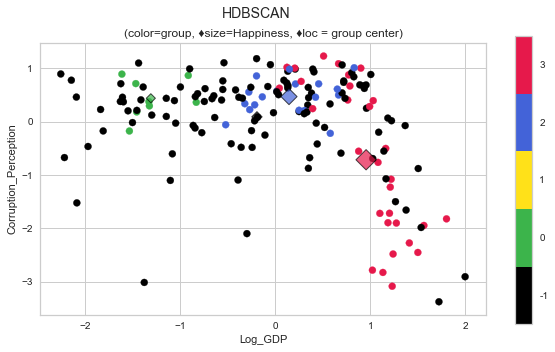

In [96]:
plot_cluster('Log_GDP', 'Corruption_Perception', 'HDBSCAN', data=whr_grps, centers=cent_hd, title='HDBSCAN');

In [100]:
scores_hd = score_clusters(whrX,clabels_hd); scores_hd

{'silhouette': -0.06289074714996329,
 'calinski_harabasz': 14.315184058617332,
 'davies_bouldin': 1.9554553185648444}

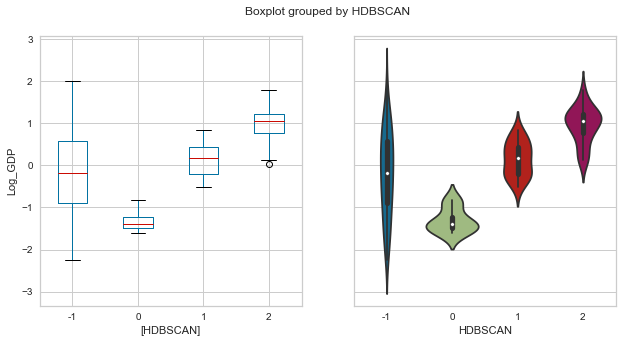

In [98]:
plot_boxolin('HDBSCAN','Log_GDP',whr_grps);

In [115]:
pd.DataFrame([scores_km,scores_ac,scores_ap,scores_gm,dict.fromkeys(scores_km.keys(),np.nan),scores_hd], index=['Kmeans', 'AgglomerativeClustering', 'AffinityPropagation', 'GaussianMixture','DBSCAN', 'HDBSCAN'])

,silhouette,calinski_harabasz,davies_bouldin
Kmeans,0.223155,51.815454,1.467267
AgglomerativeClustering,0.196852,48.287898,1.418470
AffinityPropagation,0.180791,27.846918,1.546270
GaussianMixture,0.176027,46.989627,1.645617
DBSCAN,NaN,NaN,NaN
HDBSCAN,-0.062891,14.315184,1.955455


## Conclusions

This notebook explored the World Happiness Dataset using a total of 6 models:  
K-means, Agglomerative Clustering, Affinity Propagation, Gaussian Mixture, DBSCAN, and HDBSCAN.

The was a somewhat significant degree of variation between the examined models, but those that were not prescribed a certain number of clusters arrived at a 9 or 10 groups. With this many groupings, however, it became much more difficult to see exactly how a model was making clustering decisions.

For the models which we assigned a group count of 3, K-means, Agglomerative Clustering, and Gaussian Mixture, two diagonal or vertical lines could nearly be drawn between decision boundaries by way of GDP considerations.

Only one version of one model failed to perform at all, that was DBSCAN with scaled data, the rest found some form of suitable clustering. However, the Boxplots showed that when models were given free reign over the number of clusters, they tend to have one cluster serve to explain a large range of values and another to explain an extremely tightly grouped set with many outliers.

#### Future work
One thought that was left untested was looking to see if the previous model's metrics in anyway influenced successive models. Since a new column was appended to the dataset and not removed, there is indeed a possibility of this happening. 
A good deal more EDA could be done on this dataset by looking at relationships between variables in a market basic analysis fashion. As always, there are many different hyperparamaters that could still be experimented with, as well as other clustering models like Spectral, Ward, and MeanShift that might yield interesting results. Additionally, and perhaps most poignantly, only `Log_GDP` and `Corruption_Perception` were explored, the rest were left untouched, thus leaving a significant portion of the data not truly explored to its fullest.

### References

#### Code & Docs:
1. https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python/notebook
2. https://stackoverflow.com/a/42505051
3. https://matplotlib.org/api/colorbar_api.html?highlight=colorbar#module-matplotlib.colorbar
4. https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
5. https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
6. https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
7. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html
8. https://plot.ly/python/choropleth-maps/
9. https://community.plot.ly/t/additional-measures-in-hover-text/5747

#### Text: 
1. https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
3. https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
4. https://scikit-learn.org/stable/modules/clustering.html
5. https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

#### Other:
1. https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
2. https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87
3. https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
4. https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779